In [13]:
#Set your Imports
import os
import sys
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Add the project root to sys.path
notebook_dir = os.path.dirname(os.path.abspath('data.ipynb'))
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from datasharing.datasharing import DataSharingClient

In [184]:
#Connect to datasharing client
duckdbpath="/data_challenge/datasharing/dataset/dataset.duckdb"
client = DataSharingClient(duckdb_path=duckdbpath)
#client = DataSharingClient(duckdb_path=duckdbpath,duckdb_region='us-east-1') #Uncomment if cloest to us=east-1

It's data time!
You can query datasets in the "eu-west-3" region


In [6]:
# Define the S3 URI and local path
s3_uri = 's3://oceandatachallengebucket/public/francetax.parquet'
local_path = '/data_challenge/datasharing/dataset/francetax.parquet'

# Download the dataset
client.download_dataset(s3_uri, local_path)


Downloaded s3://oceandatachallengebucket/public/francetax.parquet to /Users/yingyingzhang/man_grp_assignment/data_challenge/datasharing/dataset/francetax.parquet


In [ ]:
#Connect to dataset
#s3_uri = "s3://oceandatachallengebucket/public/francetax.parquet" Uncomment this for us-east-1
#Change s3_uri to local_path and change the variable when calling the methid if you want to work with local files
local_path = '/Users/yingyingzhang/man_grp_assignment/data_challenge/datasharing/dataset/francetax.parquet'
#s3_uri = "s3://oceandatachallenges/public/francetax.parquet"
view_name = "francetax"
client.create_view(local_path, view_name)

## Calculate Tax Revenue

In [105]:
# select column name has word pattern
query = "select * from information_schema.columns where table_name='francetax' and column_name like '%MONTANT REEL%'"
coln = client.query(query)

Query: select * from information_schema.columns where table_name='francetax' and column_name like '%MONTANT REEL%'


In [ ]:
# Create colomn name list for tax revenue table
col_name = coln['column_name'].tolist()
columns = [f'"{col}"' for col in col_name]
col_str = ', '.join(columns)
print(col_str)

In [ ]:
# tax revenue table: year, municiple etc
tax_revenue = client.query(f'SELECT ANNEE as year, "Libellé commune" as commune, {col_str} from francetax')

In [122]:
tax_revenue.shape
tax_revenue.dtypes

year                                                                                    int64
commune                                                                                object
FNB - COMMUNE / MONTANT REEL                                                           object
FNB - SYNDICATS ET ORG.ASSIMILES /  MONTANT REEL                                       object
FNB - GFP / MONTANT REEL                                                               object
TAFNB - COMMUNE / MONTANT REEL NET                                                     object
TAFNB - GFP / MONTANT REEL                                                             object
TAFNB - METROPOLE DU GRAND PARIS / MONTANT REEL                                       float64
FNB - TSE / MONTANT REEL                                                               object
FNB - TSE GRAND PARIS OU EPFL GUADELOUPE OU EPFL MARTINIQUE / MONTANT REEL             object
FNB - GEMAPI / MONTANT REEL INTERCOMMUNALITE                

In [111]:
# drop duplicates
tax_revenue.drop_duplicates(inplace=True)
tax_revenue.shape

(1493953, 37)

In [129]:
# cast tax cols to numeric type
import pandas as pd
for col in col_name:
    tax_revenue[col] = pd.to_numeric(tax_revenue[col], errors='coerce')

In [130]:
# calculate total_revenue by summing all tax income cols
tax_revenue['total_revenue']=tax_revenue[col_name].sum(axis=1)

top 5 municipalities are very constent, from original dataset, in 1994, Lyon showed up as Lyon*, here will consider them to be the same municipality; from 2018 onwards, there's no PARIS but VILLE DE PARIS came up as a new one.

In [159]:
# Function to get top 5 and bottom 5 cities
def get_top_bottom(df):
    top_5 = df.nlargest(5, 'total_revenue')['commune'].tolist()
    bottom_5 = df.nsmallest(5, 'total_revenue')['commune'].tolist()
    return pd.Series([top_5, bottom_5], index=['top5', 'bottom5'])

# Apply the function to each group
result_df = tax_revenue.groupby('year').apply(get_top_bottom).reset_index()

# Display the resulting DataFrame
print(result_df)

    year                                               top5  \
0   1982           [PARIS, MARSEILLE, LYON, NICE, TOULOUSE]   
1   1983           [PARIS, MARSEILLE, NICE, LYON, TOULOUSE]   
2   1984           [PARIS, MARSEILLE, NICE, LYON, TOULOUSE]   
3   1985           [PARIS, MARSEILLE, NICE, LYON, TOULOUSE]   
4   1986           [PARIS, MARSEILLE, NICE, LYON, TOULOUSE]   
5   1987           [PARIS, MARSEILLE, NICE, TOULOUSE, LYON]   
6   1988           [PARIS, MARSEILLE, NICE, TOULOUSE, LYON]   
7   1989           [PARIS, MARSEILLE, NICE, TOULOUSE, LYON]   
8   1990           [PARIS, MARSEILLE, NICE, TOULOUSE, LYON]   
9   1991           [PARIS, MARSEILLE, NICE, TOULOUSE, LYON]   
10  1992           [PARIS, MARSEILLE, NICE, LYON, TOULOUSE]   
11  1993           [PARIS, MARSEILLE, NICE, LYON, TOULOUSE]   
12  1994         [PARIS, MARSEILLE, NICE, LYON *, TOULOUSE]   
13  1995           [PARIS, MARSEILLE, NICE, LYON, TOULOUSE]   
14  1996           [PARIS, MARSEILLE, NICE, LYON, TOULO

/var/folders/r9/dbcw7lbn795c8kmrfrhcb8q40000gn/T/ipykernel_5920/742139638.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = tax_revenue.groupby('year').apply(get_top_bottom).reset_index()


In [179]:
# Extract all unique municipality names from the bottom 5 list
unique_municipalities = set()

for municipalities in result_df['bottom5']:
    unique_municipalities.update(municipalities)

unique_municipalities = list(unique_municipalities)
print(unique_municipalities)

['CUMIERES LE MORT HOMME', 'SAUL', 'AWALA YALIMAPO', 'HAUMONT-PRES-SAMOGNEUX', 'NEUVILLE SUR OISE', "L'ISLE D'ABEAU", 'CAMOPI', 'VAULX-MILIEU', 'ILE DE SEIN', 'LAUX-MONTAUX', 'TREBONS DE LUCHON', 'HAUMONT PRES SAMOGNEUX', 'TREBONS-DE-LUCHON', 'GRAND-SANTI', 'BEAUMONT-EN-VERDUNOIS', 'GRAND SANTI', 'SAINT-BARTHELEMY', 'LEMENIL MITRY', 'GRAND SANTI PAPAICHTON', 'ILE-MOLENE', 'SAINT BARTHELEMY', 'ARDENGOST', 'BINOS', 'LEMENIL-MITRY', 'UZ', 'ILE-DE-SEIN', 'PENNES LE SEC', 'CHAMBORD', 'APATOU', 'SAINT-BARTHELEMY(ILE)', 'BEAUMONT EN VERDUNOIS', 'FOUR', 'FLEURY DEVANT DOUAUMONT', 'MONTFORT LE GESNOIS', 'DOUAUMONT', 'MARIPASOULA', 'FLEURY-DEVANT-DOUAUMONT', 'LANCON', 'ILE MOLENE', 'PAPAICHTON', 'LOUVEMONT-COTE-DU-POIVRE', 'POMMEROL', 'LOUVEMONT COTE DU POIVRE', 'RIOMS']


In [143]:
# Filter for the year 2018
# Here I checked since 2018, Paris disappeared and replaced by ville de paris
df_2018 = tax_revenue[tax_revenue['year'] == 2018]

# Find city names that contain "paris" (case-insensitive)
cities_with_paris = df_2018[df_2018['commune'].str.contains('paris', case=False, na=False)]

# Get the city names
city_names = cities_with_paris['commune'].unique()

# Display the result
print(city_names)

['SEYSSINET PARISET' 'DAMPARIS' 'LE TOUQUET PARIS PLAGE' "PARIS L'HOPITAL"
 'VILLE DE PARIS' 'VILLEPARISIS' 'PARISOT' 'CORMEILLES EN PARISIS'
 'FONTENAY EN PARISIS']


In [27]:
#Query a view or table and return a pandas dataframe
query = "SELECT count(*) as No_of_Column FROM information_schema.columns WHERE table_name ='francetax';"
df = client.query(query)
print(df)

Query: SELECT count(*) as No_of_Column FROM information_schema.columns WHERE table_name ='francetax';
   No_of_Column
0          1181


No_of_Column    int64
dtype: object

In [ ]:
query = 'SELECT * from francetax LIMIT 10'
result_df = client.query(query)
print(result_df)

In [ ]:
# cols and dtypes
result_df.info(verbose=True)

In [30]:
year = client.query('SELECT ANNEE from francetax')
year.notna().sum()
# no NAN value in ANNEE

Query: SELECT ANNEE from francetax


ANNEE    1528922
dtype: int64

### Plot Grouped Bar Chart for top5/bottom5 Municipalities

In [170]:
df = tax_revenue

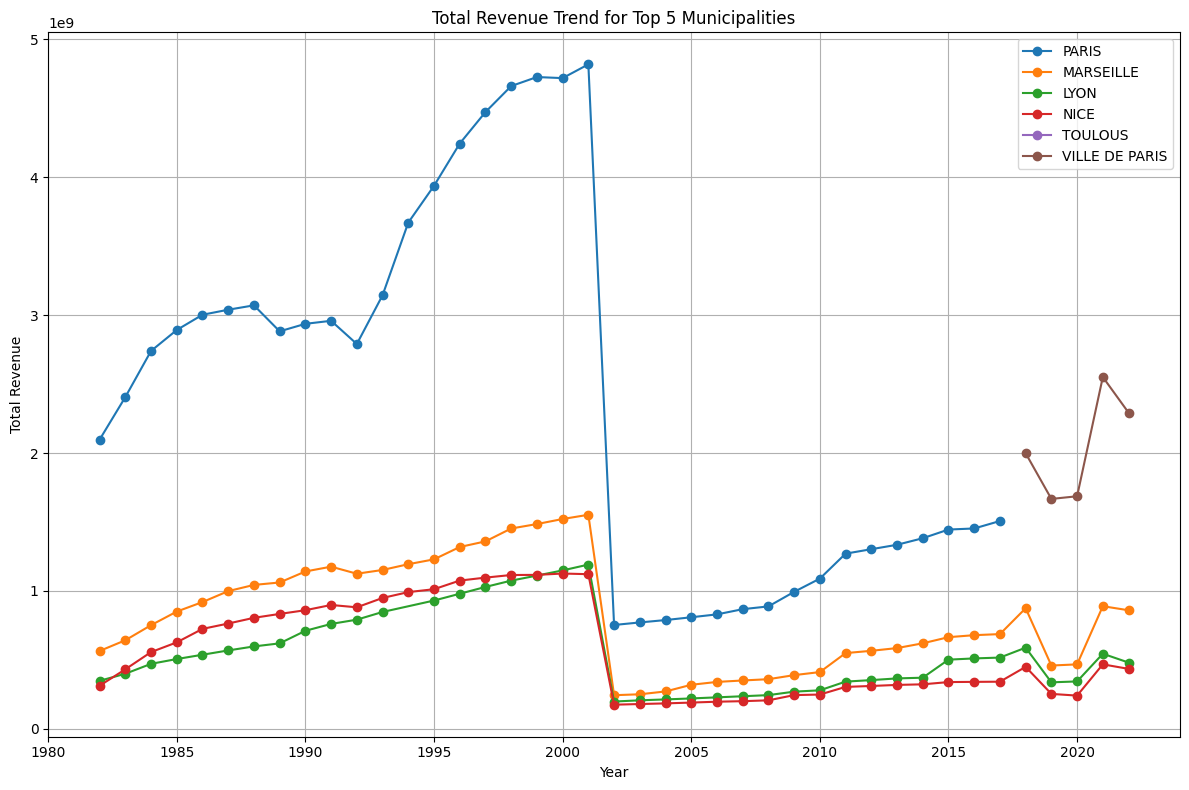

In [176]:
# Define the top 5 municipalities
top_5_municipalities = ['PARIS', 'MARSEILLE', 'LYON', 'NICE', 'TOULOUS', 'VILLE DE PARIS']

# Filter the dataframe for the top 5 municipalities
df_top5 = df[df['commune'].isin(top_5_municipalities)]

# Plot the trend of total_revenue for the top 5 municipalities over the years
fig, ax = plt.subplots(figsize=(12, 8))

for municipality in top_5_municipalities:
    df_municipality = df_top5[df_top5['commune'] == municipality]
    ax.plot(df_municipality['year'], df_municipality['total_revenue'], marker='o', label=municipality)

ax.set_xlabel('Year')
ax.set_ylabel('Total Revenue')
ax.set_title('Total Revenue Trend for Top 5 Municipalities')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/r9/dbcw7lbn795c8kmrfrhcb8q40000gn/T/ipykernel_5920/4127032805.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


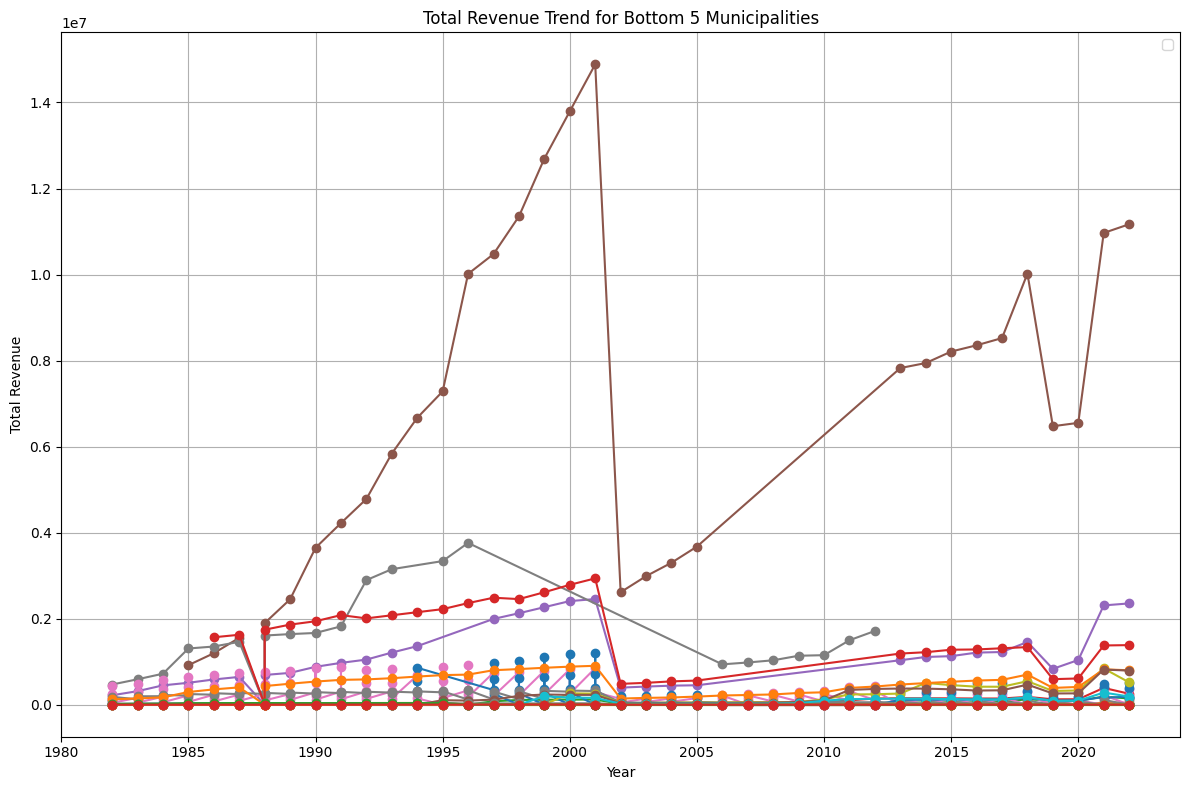

In [183]:
# Define the top 5 municipalities
bottom_5_municipalities = unique_municipalities

# Filter the dataframe for the bottom 5 municipalities
df_bottom5 = df[df['commune'].isin(bottom_5_municipalities)]

# Plot the trend of total_revenue for the top 5 municipalities over the years
fig, ax = plt.subplots(figsize=(12, 8))

for municipality in bottom_5_municipalities:
    df_municipality = df_bottom5[df_bottom5['commune'] == municipality]
    ax.plot(df_municipality['year'], df_municipality['total_revenue'], marker='o')

ax.set_xlabel('Year')
ax.set_ylabel('Total Revenue')
ax.set_title('Total Revenue Trend for Bottom 5 Municipalities')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

### Revenue Growth

In [ ]:
# calculate revenue growth
df = tax_revenue[['year', 'commune', 'total_revenue']]
df.set_index('commune', inplace=True)

# Calculate growth rates
years = [2000, 2005, 2010, 2015, 2020]
growth_rates = pd.DataFrame(index=df.index)

for i in range(1, len(years)):
    growth_rates[f'{years[i-1]}-{years[i]}'] = (df[years[i]] - df[years[i-1]]) / df[years[i-1]]

# Average annual growth rate over different periods
growth_rates['5_year_avg'] = growth_rates[['2000-2005', '2005-2010', '2010-2015', '2015-2020']].mean(axis=1)
growth_rates['10_year_avg'] = growth_rates[['2000-2010', '2010-2020']].mean(axis=1)
growth_rates['15_year_avg'] = growth_rates[['2000-2015', '2005-2020']].mean(axis=1)
growth_rates['20_year_avg'] = growth_rates[['2000-2020']].mean(axis=1)

# Categorize based on 5-year average growth rate
growth_categories = pd.cut(growth_rates['5_year_avg'], bins=[-np.inf, 0, 0.02, 0.05, np.inf], labels=['Negative', 'Low', 'Moderate', 'High'])

# Add category to the dataframe
growth_rates['category_5_year'] = growth_categories

# Display results
print(growth_rates)

### Correlation between tax revenue and population

In [192]:
df = tax_revenue[['year', 'commune', 'total_revenue']]
df_pop = client.query('SELECT ANNEE as year, "Libellé commune" as commune, "POPULATION TOTALE (MUNICIPALE ET COMPTEE A PART)  - Source saisies application FDL" as population from francetax')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Query: SELECT ANNEE as year, "Libellé commune" as commune, "POPULATION TOTALE (MUNICIPALE ET COMPTEE A PART)  - Source saisies application FDL" as population from francetax


In [198]:
df_pop.drop_duplicates(inplace=True)
df_pop.shape

(1461693, 3)

In [ ]:
new_df = pd.merge(df, df_pop, how = 'left', on=['year', 'commune'])
# new_df = df.join(df_pop, on=['year', 'commune'], how = 'left')
new_df.shape

In [202]:
new_df.drop_duplicates(inplace=True)
new_df.shape

(1713764, 4)

In [213]:
df_cleaned = new_df.dropna(subset=['population', 'total_revenue'])

In [214]:
df_cleaned.shape

(1310935, 4)

In [208]:
correlation = df_cleaned[['population', 'total_revenue']].corr()
print(correlation)

               population  total_revenue
population       1.000000       0.685434
total_revenue    0.685434       1.000000


In [ ]:
# Plot scatter plot using matplotlib
plt.figure(figsize=(10, 6))

# Loop through each commune to plot them separately for different colors
communes = df_cleaned['commune'].unique()
for commune in communes:
    df_commune = df_cleaned[df_cleaned['commune'] == commune]
    plt.scatter(df_commune['population'], df_commune['total_revenue'], label=commune)

plt.xlabel('Population')
plt.ylabel('Total Revenue')
plt.title('Population vs Total Revenue')
plt.legend(title='Commune')
plt.grid(True)
plt.tight_layout()
plt.show()

In [224]:
# Initialize a list to store correlations for each city
correlations = []
df = df_cleaned
# Group data by commune and calculate correlation for each group
grouped = df.groupby('commune')

for name, group in grouped:
    # Calculate correlation between population and total_revenue for each city
    corr = group[['population', 'total_revenue']].corr().iloc[0, 1]
    correlations.append(corr)

# Compute the average correlation
average_correlation = sum(correlations) / len(correlations)

# Display the average correlation
print(f"Average correlation between population and total_revenue across all cities: {average_correlation:.2f}")

# import ace_tools as tools; tools.display_dataframe_to_user(name="City-wise Correlations", dataframe=pd.DataFrame({'City': list(grouped.groups.keys()), 'Correlation': correlations}))

# Display individual correlations for verification
city_correlation_df = pd.DataFrame({'City': list(grouped.groups.keys()), 'Correlation': correlations})
print(city_correlation_df)

Average correlation between population and total_revenue across all cities: nan
                         City   Correlation
0                       #NOM? -5.342464e-17
1            - ANSE- BERTRAND           NaN
2              - BAIE MAHAULT -9.999546e-01
3                   - BAILLIF  9.999963e-01
4               - BASSE-TERRE  9.999707e-01
...                       ...           ...
52201              ZUDAUSQUES  7.208851e-02
52202               ZUTKERQUE -3.180768e-01
52203               ZUYDCOOTE -3.202509e-01
52204               ZUYTPEENE -5.387097e-01
52205  lA CHAPELLE SOUS BRANC  8.024065e-01

[52206 rows x 2 columns]


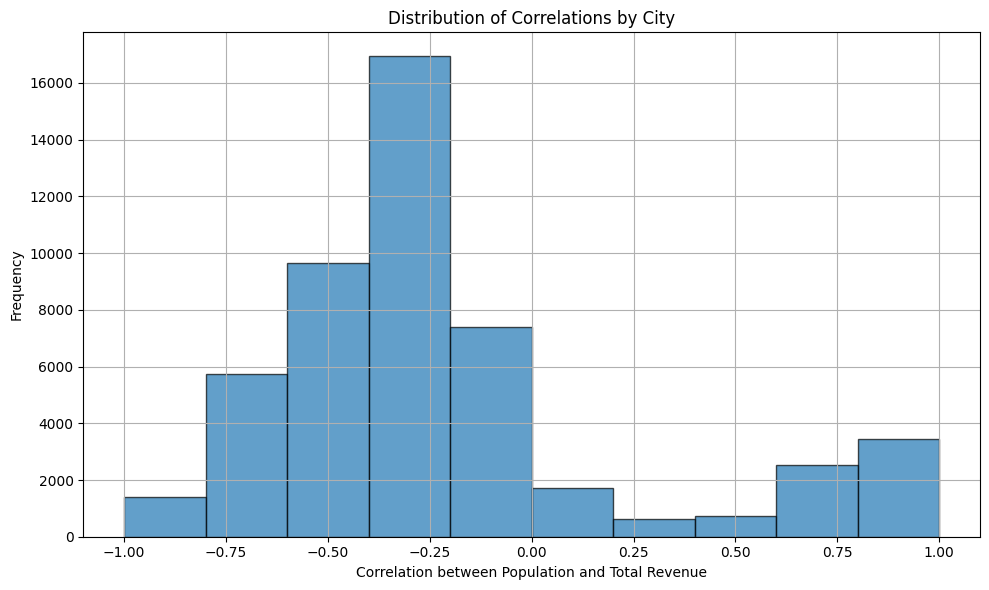

In [230]:
# Plot histogram using matplotlib
plt.figure(figsize=(10, 6))
plt.hist(city_correlation_df['Correlation'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Correlation between Population and Total Revenue')
plt.ylabel('Frequency')
plt.title('Distribution of Correlations by City')
plt.grid(True)
plt.tight_layout()
plt.show()

## Different Topic

In [ ]:
year['ANNEE'].value_counts()

In [41]:
mani = client.query('SELECT "Libellé commune" , ANNEE FROM francetax')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Query: SELECT "Libellé commune" , ANNEE FROM francetax


In [76]:
temp = tax_revenue.groupby(['year','mani']).size().reset_index(name='row_count')
print(temp)

         year                    mani  row_count
0        1982                    AAST          1
1        1982              ABAINVILLE          1
2        1982               ABANCOURT          1
3        1982               ABAUCOURT          1
4        1982    ABAUCOURT HAUTECOURT          1
...       ...                     ...        ...
1394736  2022              ZUDAUSQUES          1
1394737  2022               ZUTKERQUE          1
1394738  2022               ZUYDCOOTE          1
1394739  2022               ZUYTPEENE          1
1394740  2022  lA CHAPELLE SOUS BRANC          1

[1394741 rows x 3 columns]


In [9]:
# View all tables and views in duckdb
tables = client.list_tables()
print(tables)

[('francetax', 'VIEW')]


In [ ]:
# Query a view or table and create a duckdb table
query = "SELECT COUNT(*) FROM francetax;"
new_table_name = "francerowcount"

# Create a new table from the query
client.query(query, new_table_name)

In [ ]:
#Export a duckdb table as csv or parquet
table_names = ["francerowcount"]
output_dir = "/data_challenge/datasharing/data"

# Export the tables to CSV format
client.export_tables(table_names, output_dir, "csv")#parquet for parquet export